In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import  r2_score




In [3]:

# Load the  csv files
fulfilment_center_info = pd.read_csv('fulfilment_center_info.csv')
meal_info = pd.read_csv('meal_info.csv')
train = pd.read_csv('train.csv')

In [4]:
# Shape of the dataframes
print(fulfilment_center_info.shape)
print(meal_info.shape)
print(train.shape)

(77, 5)
(51, 3)
(456548, 9)


In [5]:
# Join datasets on the 'center_id' and 'meal_id' columns and remove id columns
train_combined = pd.merge(train, fulfilment_center_info, on='center_id', how='left')
train_combined = pd.merge(train_combined, meal_info, on='meal_id', how='left')
train_combined.drop(['id'], axis=1, inplace=True)

In [6]:
# Create a new column 'if_discount' based on the checkout price and discount price
train_combined['if_discount'] = (train_combined['base_price'] != train_combined['checkout_price']).astype(int)
train_combined.tail()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,if_discount
456543,145,61,1543,484.09,484.09,0,0,68,473,77,TYPE_A,4.5,Desert,Indian,0
456544,145,61,2304,482.09,482.09,0,0,42,473,77,TYPE_A,4.5,Desert,Indian,0
456545,145,61,2664,237.68,321.07,0,0,501,473,77,TYPE_A,4.5,Salad,Italian,1
456546,145,61,2569,243.50,313.34,0,0,729,473,77,TYPE_A,4.5,Salad,Italian,1
456547,145,61,2490,292.03,290.03,0,0,162,473,77,TYPE_A,4.5,Salad,Italian,1


<ipython-input-10-111629882cfb>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train_combined.drop(columns=[ 'week', 'center_id', 'meal_id']).corr( )


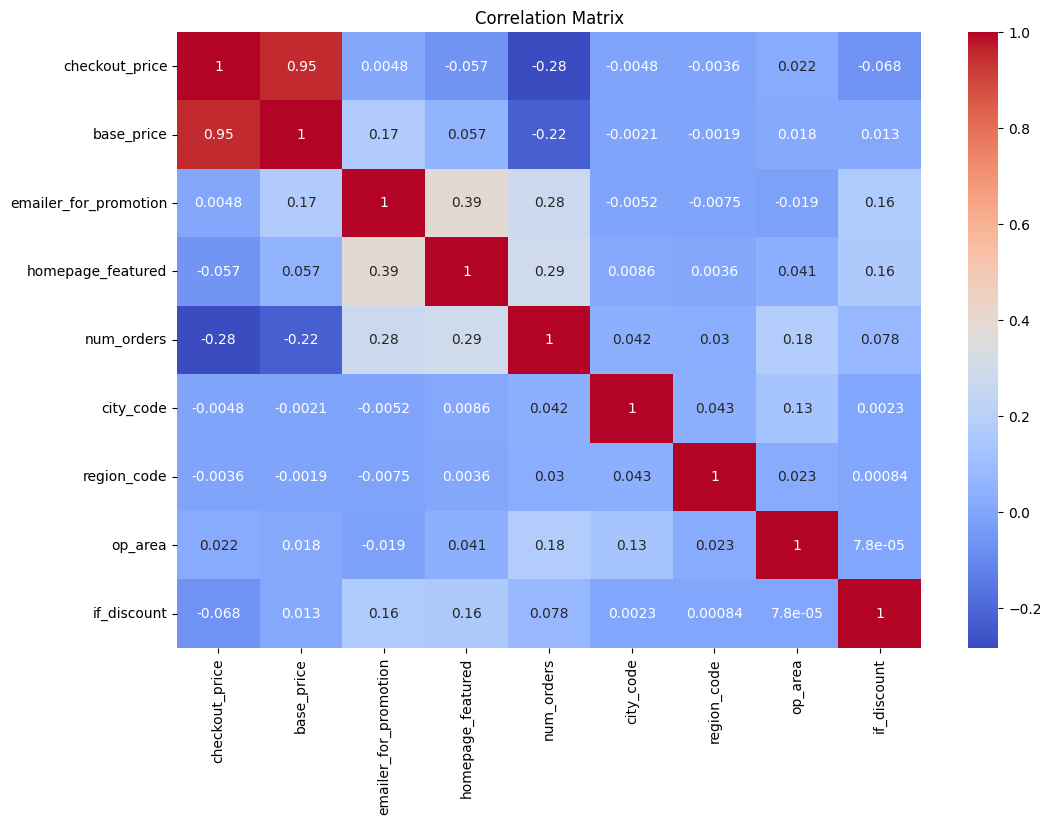

In [10]:
# Correlation Matrix
corr_matrix = train_combined.drop(columns=[ 'week', 'center_id', 'meal_id']).corr( )
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Preprocessing for model building

In [11]:
  # Select the columns for feature encoding and scaling
categorical_cols = train_combined.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = train_combined.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('num_orders')  # Exclude the target variable from scaling


In [18]:
# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ]
)


In [19]:
# Define the random forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=101)

In [20]:
# Create the pipeline for random forest
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', rf_model)])

In [21]:
# Separate features and target variable
X = train_combined.drop('num_orders', axis=1)
y = train_combined['num_orders']

In [23]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)


In [24]:
# Train the random forest model
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['week', 'center_id',
                                                   'meal_id', 'checkout_price',
                                                   'base_price',
                                                   'emailer_for_promotion',
                                                   'homepage_featured',
                                                   'city_code', 'region_code',
                                                   'op_area', 'if_discount']),
                                                 ('cat', OneHotEncoder(),
                                                  ['center_type', 'category',
                                                   'cuisine'])])),
                ('model', RandomForestRegressor(random_state=101))])

In [25]:
y_pred_rf = pipeline_rf.predict(X_test)

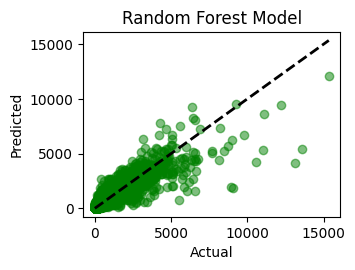

In [26]:

# Plot for random forest
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred_rf, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title(f'Random Forest Model')
plt.xlabel('Actual')
plt.ylabel('Predicted')



plt.tight_layout()
plt.show()


In [27]:
r2 = r2_score(y_test, y_pred_rf)
print('r2 score for  model is', r2)

r2 score for  model is 0.8553149362466019


Making predictions for the next 10 weeks using test set

In [ ]:
# Load the test dataset
test_data = pd.read_csv('test.csv')

In [ ]:
#Combine test data with meal_info and fulfilment_center_info
test_combined = pd.merge(test_data, meal_info, on='meal_id', how='left')
test_combined = pd.merge(test_combined, fulfilment_center_info, on='center_id', how='left')



In [ ]:
# Add the 'if_discount' column and remove id
test_combined['if_discount'] = (test_combined['base_price'] != test_combined['checkout_price']).astype(int)
test_combined = test_combined.drop(['id'], axis=1)


In [ ]:
# Select the columns for feature encoding and scaling
categorical_cols = test_combined.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = test_combined.select_dtypes(include=['int64', 'float64']).columns.tolist()


In [ ]:
# Reorder the columns of the test set to match the training set
column_order = [col for col in train_combined.columns if col != 'num_orders']
test_combined = test_combined[column_order]




In [ ]:
# Preprocess the test data
X_test_preprocessed = preprocessor.transform(test_combined)

In [ ]:
# First, select only the expected columns order from the test data
X_test_preprocessed = test_combined[column_order]


In [ ]:
# Predict the 'num_orders' using the Random Forest model
test_predictions = pipeline_rf.predict(X_test_preprocessed)

In [ ]:
# Add the predictions to the test dataframe
test_data['num_orders_predicted'] = test_predictions

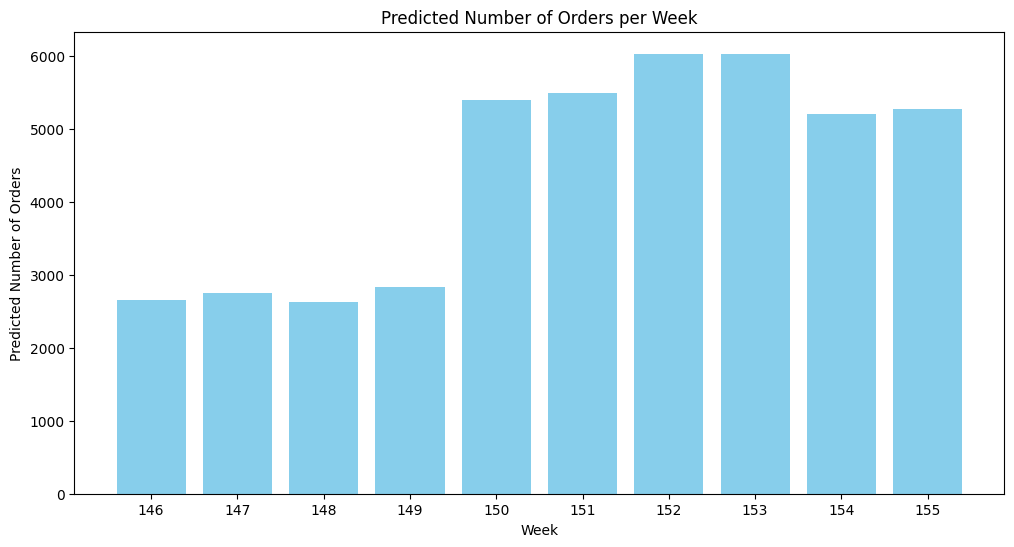

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(test_data['week'], test_data['num_orders_predicted'], color='skyblue')
plt.xlabel('Week')
plt.ylabel('Predicted Number of Orders')
plt.title('Predicted Number of Orders per Week')
plt.xticks(sorted(test_data['week'].unique()))
plt.show()

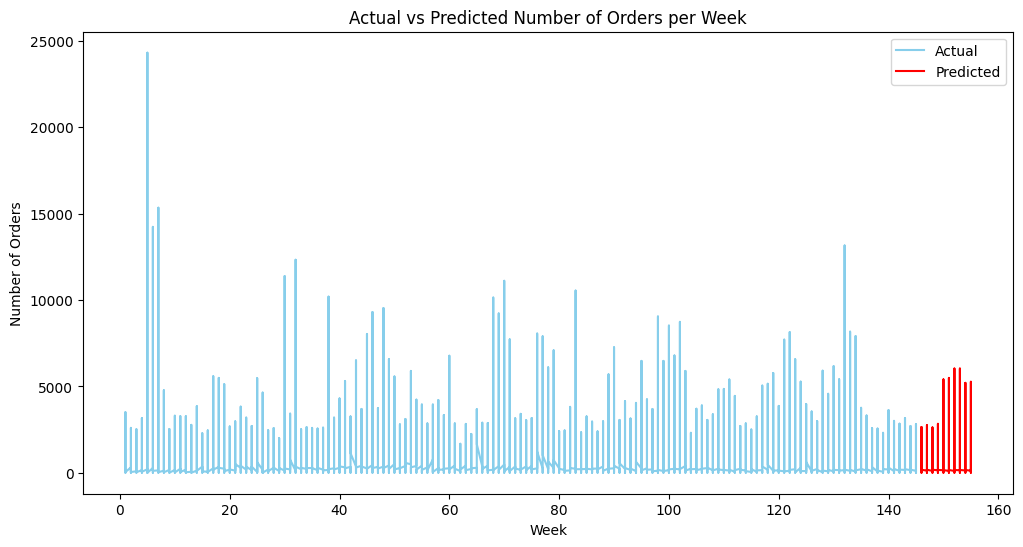

In [ ]:
# plot the actual and predicted values for next 10 weeks
plt.figure(figsize=(12, 6))
plt.plot(train['week'], train['num_orders'], color='skyblue', label='Actual')
plt.plot(test_data['week'], test_data['num_orders_predicted'], color='red', label='Predicted')
plt.xlabel('Week')
plt.ylabel('Number of Orders')
plt.title('Actual vs Predicted Number of Orders per Week')
plt.legend()
plt.show()




In [ ]:

# Plot of avg orders per week actual vs predicted
# Calculate the average number of orders per week for the actual and predicted values
actual_avg_orders = train.groupby('week')['num_orders'].mean()
predicted_avg_orders = test_data.groupby('week')['num_orders_predicted'].mean()



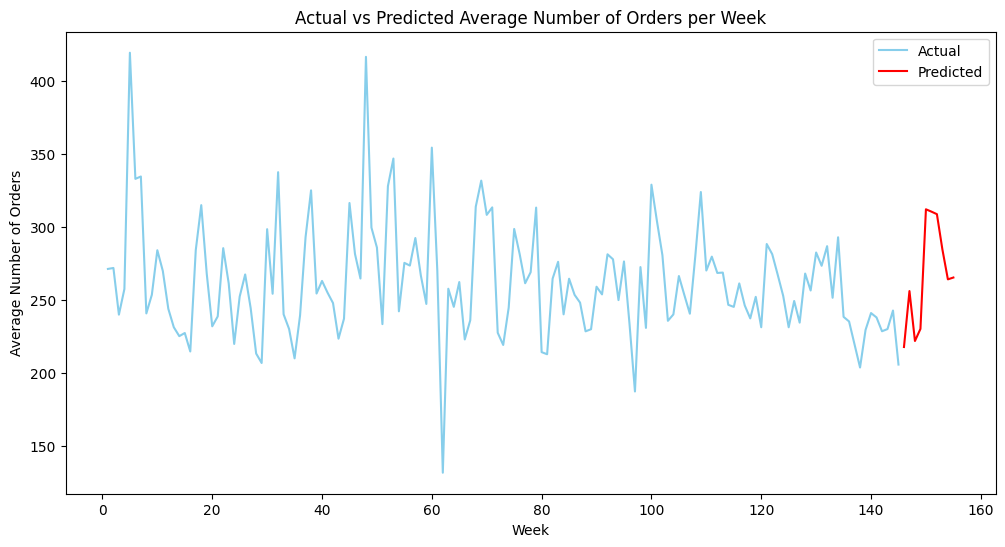

In [ ]:
# Plot the actual and predicted average number of orders per week
plt.figure(figsize=(12, 6))
plt.plot(actual_avg_orders.index, actual_avg_orders, color='skyblue', label='Actual')
plt.plot(predicted_avg_orders.index, predicted_avg_orders, color='red', label='Predicted')
plt.xlabel('Week')
plt.ylabel('Average Number of Orders')
plt.title('Actual vs Predicted Average Number of Orders per Week')
plt.legend()
plt.show()